# ДОМАШНЯЯ РАБОТА "поиск изменений во временном ряде"

Данильченко Вадим

In [2]:
from collections import defaultdict
np.random.seed(seed=111111)
np.set_printoptions(precision=3, suppress=True)

## 1. Простое мат ожидание

* Расчитываем среднее значение в каждой точке
* Сигнализируем об изменении, если значение сигнала превосходит мат ожидание на какой-то порог

In [36]:
class MeanDetector:
    def __init__(self, threshold):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    def check(self, new_signal_value): 
        threshold_level = self.mean * self.threshold
        
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

In [16]:
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    
    plt.figure(figsize=(14,8))
    plt.plot(signal, 'b.')
    plt.plot(signal, 'b-', alpha=0.15)
    plt.title('Signal')
    
    if stop_points:
        plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                      colors='r', linestyles='dotted')
    
    plt.show()

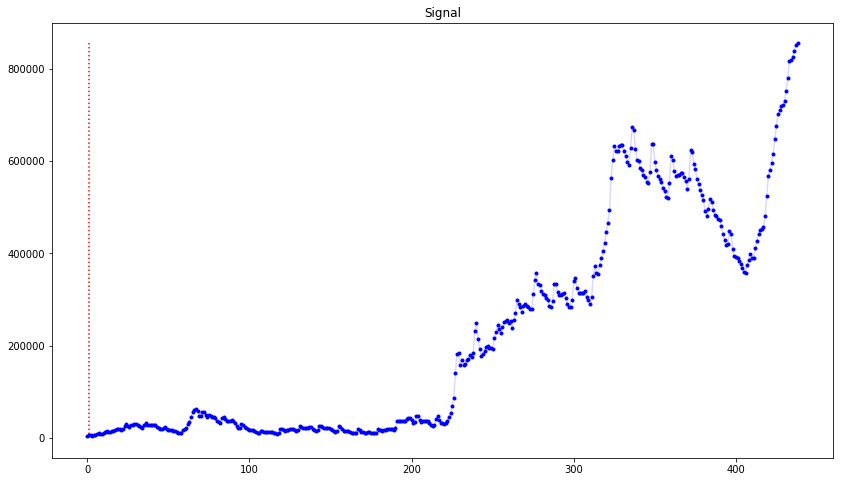

In [57]:
threshold=0.05
simulate(MeanDetector(threshold), series)

In [61]:
print(f'первое значение ряда: {series[0]}, среднее значение: {np.round(series.mean())}, {threshold*100}% от среднего: {np.round(series.mean()*threshold)} ')
print(f'значение по метрике метода: {np.round(series[0]-series.mean())}, что гораздо меньше {threshold*100}%: {np.round(series[0]-series.mean())<np.round(series.mean()*threshold)}')

первое значение ряда: 4742.0, среднее значение: 221238.0, 5.0% от среднего: 11062.0 
значение по метрике метода: -216496.0, что гораздо меньше 5.0%: True


как ввидим наше первое же значение минус среднее больше чем установленный порог в 5% от среднего, получили сигнал сразу, хотя судя по графику слишком рано.

попробуем скорректировать порог, к примеру до 200%

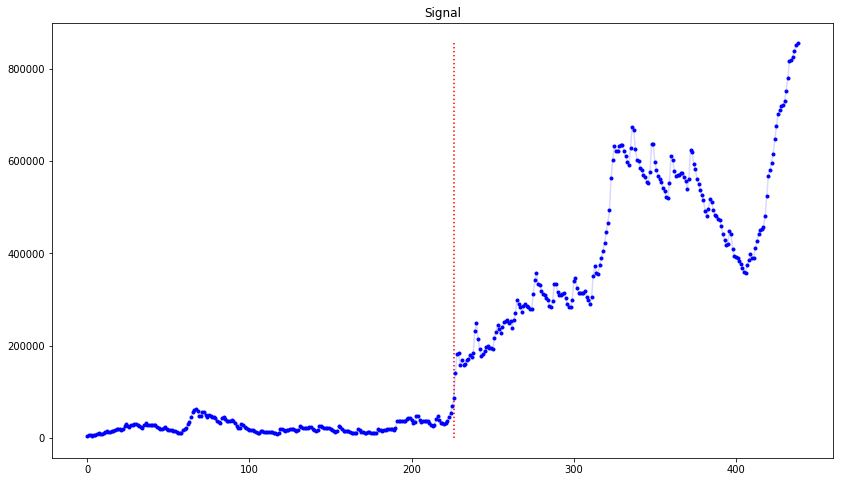

In [64]:
threshold=2
simulate(MeanDetector(threshold), series)

уже что-то симпатичное, но попробуем лучше дальше найти более научные и автоматические методы

## 2. Потоковые окна

### Используем Zscore

этот метод говорит нам, что при разнице среднего заданного размера выборки со стандартным отклонением по отношению к стандарной ошибке больше заданного порога, то наблюдаем выброс, сигнализируем (возможно не сразу)

налицо снова игра в "угадай размер окна" и "уровень сигнала"

In [79]:
class ZScoreDetector:
    def __init__(self, window_size, threshold):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


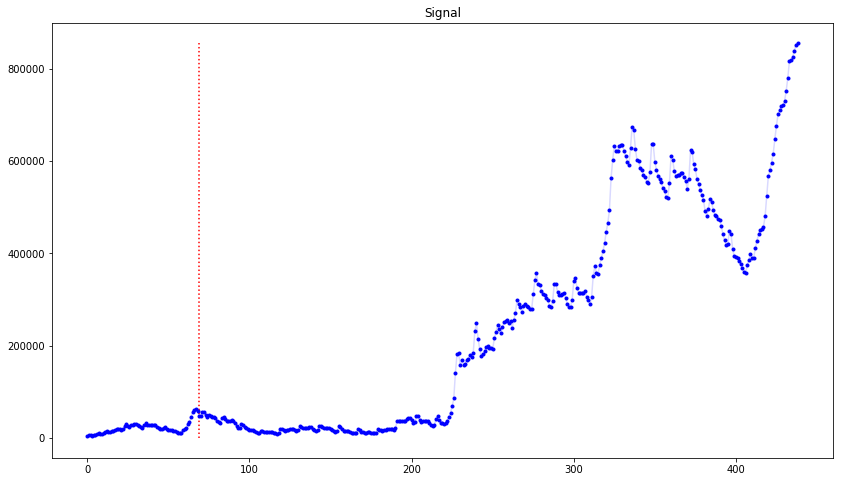

In [85]:
simulate(ZScoreDetector(window_size=10, threshold=5.0), series)

видим при выборке в 10 элементов и пороге 500% уже нет срабатывания на первом же элементе (по отношению к 1му методу), но и есть более значимые изменения, которые мы не смогли с первого раза угадать

попробуем увеличить размер окна до 100

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


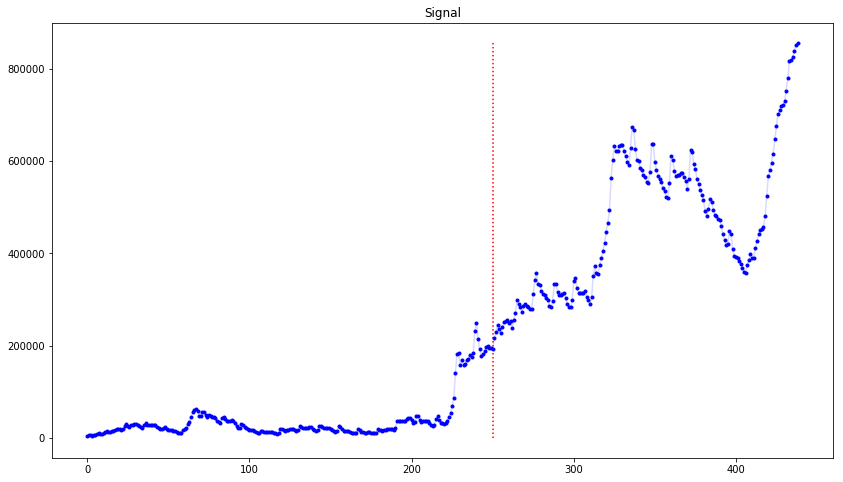

In [86]:
simulate(ZScoreDetector(window_size=100, threshold=5.0), series)

действительно большая выборка позволяет сглаживать некоторые колебания ряда, но особо крупные уходят в сигнал

попробуем добиться того же эффекта с небольшим окном и большим порогом

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


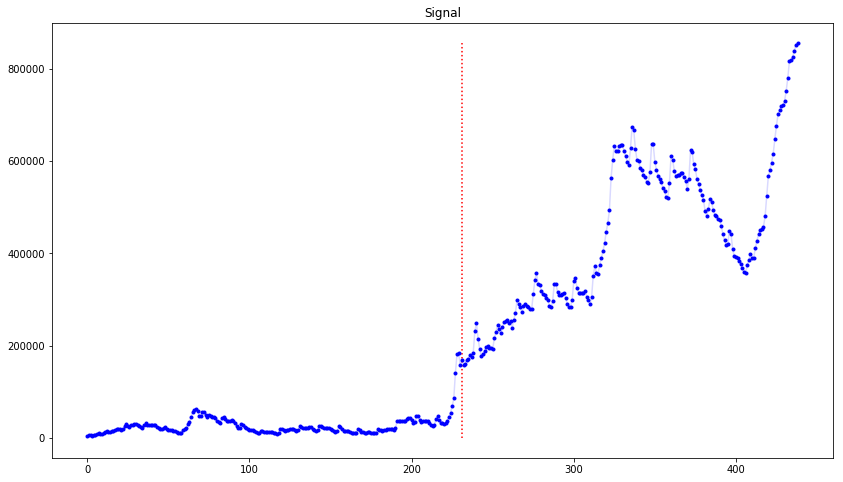

In [90]:
simulate(ZScoreDetector(window_size=10, threshold=10), series)

сигнал о крупном изменении ряда стал заметен ранее, но все равно для таких манипуляций с этими атрибутами нужно будет предварительно исследовать ряд. попробуем посмотреть дальше

### 3. Кумулятивные суммы

смысл такой - если накопилось положительное или отрицательное изменение, то рождается сигнал

попробуем подобрать параметры по амплитуде колебаний

In [133]:
__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

def detect_cusum(x, threshold, drift, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

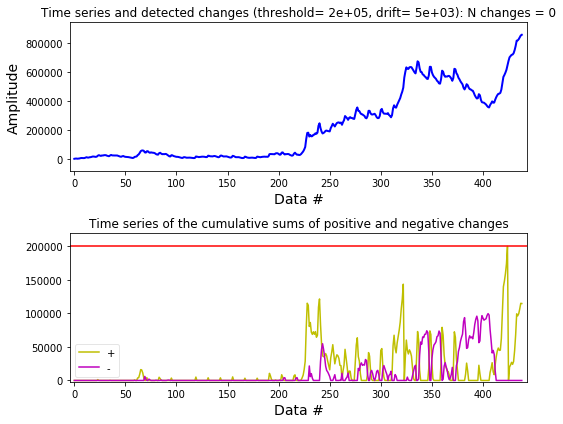

In [210]:
ta, tai, taf, amp = detect_cusum(np.array(series), 200000, 5000, True, True)

хоть на первом графике никакой индикации не происходит, на втором очень заметны накопленные положительные и отрицательные сигналы

попробуем взять выборку из первых 100 значений ряда, чтобы увидеть индикацию сигналов на первом графике

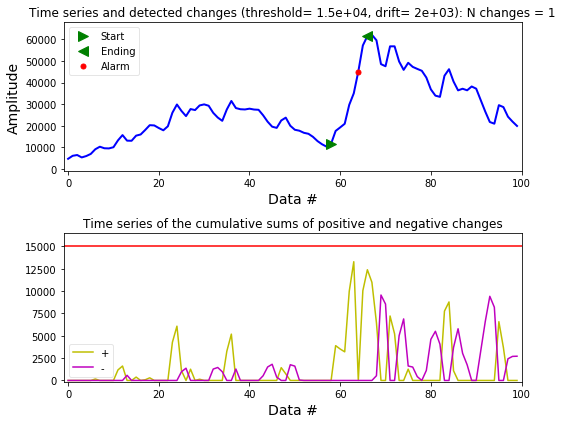

In [211]:
ta, tai, taf, amp = detect_cusum(np.array(series[:100]), 15000, 2000, True, True)

снизили амплитуду до размера текущей выборки, теперь видим, что есть максимальное изменение ряда примерно с 57го по 65е наблюдение, а также накопленный сигнал

## 4. OneClass SVM

На пальцах - пытаемся отделить гипер-плоскостью пространство известных измерений от всего остального

In [598]:
import matplotlib.font_manager
from sklearn import svm

In [836]:
series2=np.array(series).reshape(-1, 1)

In [665]:
clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)
clf.fit(series2[:352])

y_pred_train = clf.predict(series2[:352])
y_pred_test = clf.predict(series2[352:439])

In [832]:
y=series2[:-1]
Z = clf.decision_function(y)
Z = np.hstack((Z, Z))
y = y.reshape(439)

In [833]:
false_positive_train = []
false_positive_test = []
for i, t in enumerate(y_pred_train):
    if t != 1:
        false_positive_train.append((i, series2[i]))
        
for i, t in enumerate(y_pred_test):
    if t != 1:
        idx = len(y_pred_train) + i
        false_positive_test.append((idx, series2[idx]))

In [834]:
false_positive_train = np.array(false_positive_train)
false_positive_test = np.array(false_positive_test)

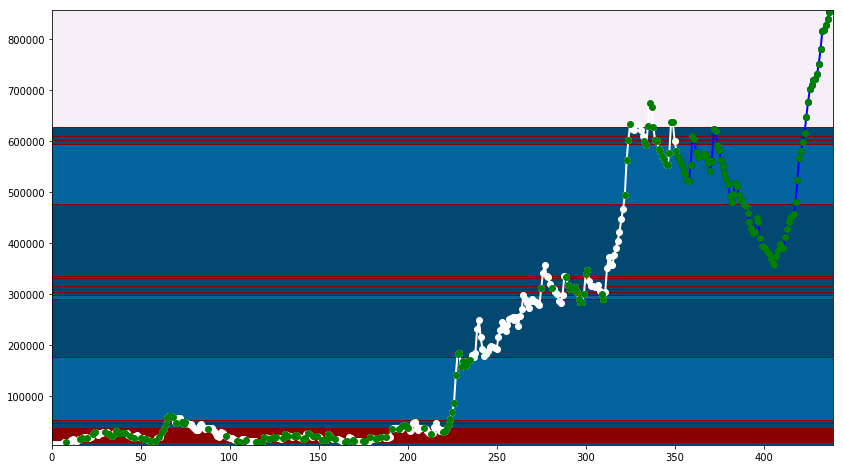

In [835]:
plt.figure(figsize=(14,8))
plt.contourf([0, 439], y, Z, cmap=plt.cm.PuBu)
plt.contour([0, 439], y, Z, levels=[0], linewidths=1, colors='darkred')
plt.plot(range(352), series2[:352], 'wo', linewidth=10)
plt.plot(range(352), series2[:352], 'w-', linewidth=2)
plt.plot(range(352,439), series2[352:439], 'bo', linewidth=10)
plt.plot(range(352,439), series2[352:439], 'b-', linewidth=2)
plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')
plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
plt.show()

на мой взгляд не то, чтобы мы могли наблюдать некоторые выбросы, а вообще весь ряд получился сильно аномальным

# выходит нет идеального метода, который бы разом решил вопрос на любых наблюдениях, все сильно зависит и от самого ряда